In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rosatX as rx
import pyccl as ccl
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)
from getdist import plots, MCSamples, loadMCSamples
from getdist.mcsamples import MCSamplesFromCobaya

Code to calculate baryonic boost factor

In [2]:
COSMO_P18 = {"Omega_c": 0.26066676,
             "Omega_b": 0.048974682,
             "h": 0.6766,
             "n_s": 0.9665,
             "sigma8": 0.8102,
             "matter_power_spectrum": "halofit"}
cosmo = ccl.Cosmology(**COSMO_P18)
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)
nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(
    mass_function=nM, halo_bias=bM, mass_def=mdef,
    log10M_max=15., log10M_min=10, nM=32)
prof_dmo = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)
k_arr = np.geomspace(1e-4, 100, 256)
lk_arr = np.log(k_arr)
a_arr = np.linspace(0.3, 1, 8)
pk_dmo = ccl.halos.halomod_Pk2D(cosmo, hmc, prof_dmo, lk_arr=lk_arr, a_arr=a_arr)

def get_pk_ratio(ks, zs, **kwargs):
    prof_bar = rx.HaloProfileNFWBaryon(mass_def=mdef, concentration=cM, **kwargs)
    pk_bar = ccl.halos.halomod_Pk2D(cosmo, hmc, prof_bar, lk_arr=lk_arr, a_arr=a_arr)
    rat = np.array([pk_bar(ks, a)/pk_dmo(ks, a) for a in 1/(1+zs)])
    return rat

$k$ and $z$ sampling

In [3]:
ks = np.geomspace(0.05, 20, 128)
zs = np.array([0, 1])

Calculate for logTAGN chains

In [4]:
d = np.load('constraints_1d.npz')
ps = np.exp(-0.5*(d['chi2'][:, -1]-np.amin(d['chi2'][:, -1])))

# Reduce the number of points to evaluate
pgood = ps > 1E-3
ps = ps[pgood]
ratios = np.array([get_pk_ratio(ks, zs, logTAGN=lT) for lT in d['logTAGN'][pgood]])

# Calculate mean and standard deviation
pnorm = np.sum(ps)
rat_mean_lT = np.sum(ps[:, None, None] * ratios, axis=0)/pnorm
rat_std_lT = np.sqrt(np.sum(ps[:, None, None] * ratios**2, axis=0)/pnorm - rat_mean_lT**2)

Calculate for 4-param model chains

In [5]:
cha = loadMCSamples('chains_cobaya/chain_cobaya_all',
                    settings={'ignore_rows': 0.2})
# Thin by a factor 20
thinfac = 20
ws = cha['weight'][::thinfac]
ratios = []
for lMc, gamma, eta_b in zip(cha['lMc'][::thinfac],
                             cha['gamma'][::thinfac],
                             cha['eta_b'][::thinfac]):
    ratios.append(get_pk_ratio(ks, zs, lMc=lMc, gamma=gamma, eta_b=eta_b))
ratios = np.array(ratios)

# Calculate mean and standard deviation
rat_mean_ch = np.sum(ratios*ws[:, None, None], axis=0)/np.sum(ws)
rat_std_ch = np.sqrt(np.sum((ratios - rat_mean_ch[None, :, :])**2*ws[:, None, None], axis=0)/np.sum(ws))

Calculate for Amon & Efstathiou model

In [6]:
def get_ratio_AE(ks, zs, Amod):
    pl = np.array([cosmo.linear_matter_power(ks, a) for a in 1/(1+zs)])
    pnl = np.array([cosmo.nonlin_matter_power(ks, a) for a in 1/(1+zs)])
    rat = Amod + pl/pnl*(1-Amod)
    return rat

# Gaussian posterior on A_mod (see Eq. 7 of 2206.11794)
Amods = np.linspace(0.3, 1.2, 256)
pAmods = np.exp(-0.5*((Amods-0.69)/0.06)**2)
ratios = np.array([get_ratio_AE(ks, zs, Amod) for Amod in Amods])
pnorm = np.sum(pAmods)
rat_mean_Am = np.sum(pAmods[:, None, None] * ratios, axis=0)/pnorm
rat_std_Am = np.sqrt(np.sum(pAmods[:, None, None] * ratios**2, axis=0)/pnorm - rat_mean_Am**2)

Plot everything!

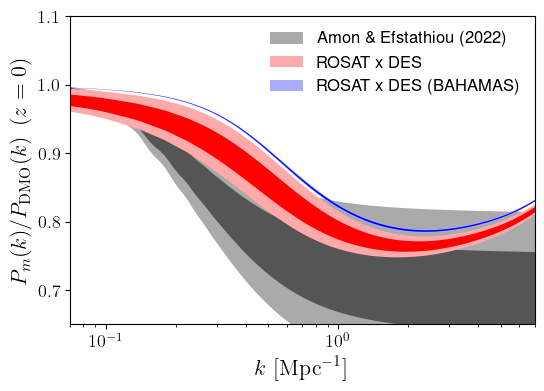

In [7]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.fill_between(ks, rat_mean_Am[0]-2*rat_std_Am[0], rat_mean_Am[0]+2*rat_std_Am[0],
                facecolor='#AAAAAA', label='Amon \& Efstathiou (2022)')
ax.fill_between(ks, rat_mean_Am[0]-rat_std_Am[0], rat_mean_Am[0]+rat_std_Am[0],
                facecolor='#555555')
ax.fill_between(ks, rat_mean_ch[0]-2*rat_std_ch[0], rat_mean_ch[0]+2*rat_std_ch[0],
                facecolor='#FFAAAA', label='ROSAT x DES')
ax.fill_between(ks, rat_mean_ch[0]-rat_std_ch[0], rat_mean_ch[0]+rat_std_ch[0],
                facecolor='#FF0000')
ax.fill_between(ks, rat_mean_lT[0]-2*rat_std_lT[0], rat_mean_lT[0]+2*rat_std_lT[0],
                facecolor='#AAAAFF', label='ROSAT x DES (BAHAMAS)')
ax.fill_between(ks, rat_mean_lT[0]-rat_std_lT[0], rat_mean_lT[0]+rat_std_lT[0],
                facecolor='#0000FF')
ax.set_xscale('log')
ax.set_xlim([0.07, 7.])
ax.set_ylim([0.65, 1.1])
ax.legend(frameon=False, fontsize=12)
ax.set_xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=16)
ax.set_ylabel(r'$P_m(k)/P_{\rm DMO}(k)\,\,\,(z=0)$', fontsize=16)
ax.tick_params(axis='both', labelsize=13)
plt.savefig('baryon_boost.pdf', bbox_inches='tight')